In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt

## Computing Drivatives by Approximation

In [2]:
def f(a,b):
    return a**2 + b

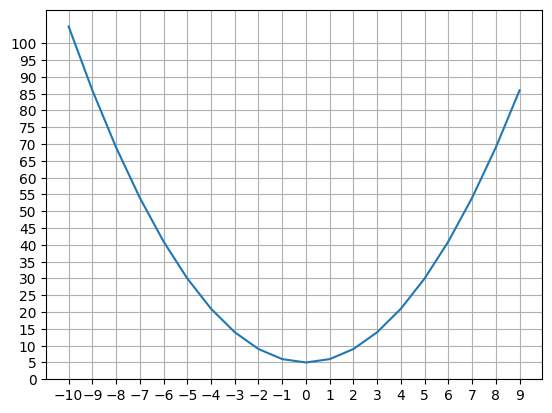

In [3]:
a = list(range(-10, 10))
b = 5
y = [f(x, b) for x in a]
plt.plot(a, y)
plt.xticks(a)
plt.yticks(range(0, max(y), 5))
plt.grid();

**Derivative Approximation**

$df/dx= f(x + h) - f(x) / h$

In [4]:
a = 3
b = 5
h = 0.0000001

df_da = (f(a+h, b) - f(a,b)) / h
df_da

6.000000087880153

## TensorFlow AutoDiff Module

In [5]:
a = tf.Variable(3.0)
b = tf.Variable(5.0)

with tf.autodiff.GradientTape() as tape:
    y = f(a,b)

print(tape.gradient(y, a).numpy())

6.0


In [6]:
a = tf.Variable(3.0)
b = tf.Variable(5.0)

with tf.autodiff.GradientTape() as tape:
    z = f(a,b)
    y = z ** 2

print(tape.gradient(y, [a,b]))

[<tf.Tensor: shape=(), dtype=float32, numpy=168.0>, <tf.Tensor: shape=(), dtype=float32, numpy=28.0>]


- *What do we need?:* $dy/da$
- *Chain Rule:* $dy/da = dy/dz * dz/da$
- $a=3, z=14 $
- $ dy/dz = 2*z=28 , dz/da = 2*a=6 $
- $ dy/da = 28*6=168$

In [7]:
## tape will automatically erased if we call gradient(), so next time calling it will raise an error
try:
    print(tape.gradient(y, [a,b]))
except:
    print("some tensorflow blah blah")

some tensorflow blah blah


In [8]:
## In order to call gradient() multiple times, we need to make gradient tape persistence

with tf.GradientTape(persistent=True) as tape:
    z = f(a,b)

print(tape.gradient(z, a))
print(tape.gradient(z, b))
del tape

tf.Tensor(6.0, shape=(), dtype=float32)
tf.Tensor(1.0, shape=(), dtype=float32)


In [9]:
## If we need to to watch ops on some non-variable tensor, we can watch them inside tape
a = tf.constant(3.0)
b = tf.constant(5.0)

with tf.GradientTape() as tape:
    tape.watch(a)
    tape.watch(b)
    y = f(a,b)
    
print(tape.gradient(y, a))

tf.Tensor(6.0, shape=(), dtype=float32)


In [10]:
## if we have multiple losses, TF automatically compute sum of losses w.r.t that parameter we want.
## to do seprate derivatives of losses regart to param, we can use jacobian

with tf.GradientTape() as g:
  x  = tf.constant([1.0, 2.0])
  g.watch(x)
  y = x ** 2

print(g.jacobian(y, x))

tf.Tensor(
[[2. 0.]
 [0. 4.]], shape=(2, 2), dtype=float32)


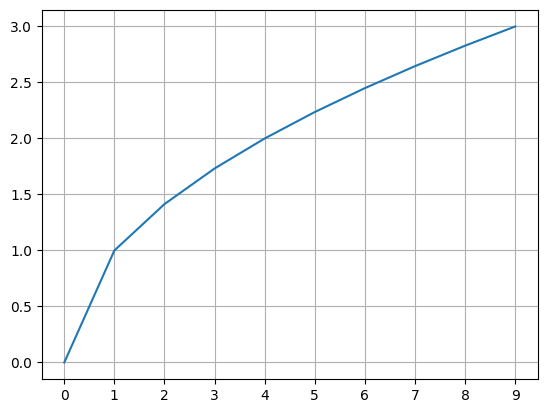

In [11]:
sqrt = (lambda x: pow(x, 0.5))
x = list(range(10))
y = [sqrt(i) for i in x]

plt.plot(x,y)
plt.xticks(x)
plt.grid();

In [12]:
## sqrt gradient at 1e-50 is inf, cause of float32 limit. to overcome, we can add a tiny amount like 1e-6 to x
x = tf.Variable(1e-50)

with tf.GradientTape(persistent=True) as tape:
    y = sqrt(x)
    z = sqrt(x + 1e-6)

print(tape.gradient(y, x).numpy(), " | ", tape.gradient(z, x).numpy())
del tape

inf  |  500.0


## Simple Training Loop

In [13]:
## lets use one of sklearn toy datasets
from sklearn.datasets import load_diabetes
X,y = load_diabetes(return_X_y=True)
print(X.shape, y.shape)

(442, 10) (442,)


In [14]:
def batched_indexes(train_len, batch_size):
    idxs = tf.random.shuffle(range(train_len))
    return [idxs[i:i+batch_size] for i in range(0, train_len, batch_size)]

In [15]:
n_epochs = 25
batch_size = 32
train_len = len(X)

loss_fn = tf.keras.losses.mse
optimizer = tf.keras.optimizers.SGD(0.01)
metric_fn = tf.keras.metrics.mae

model = tf.keras.Sequential([
    tf.keras.layers.Dense(16, activation="relu"),
    tf.keras.layers.Dense(1, activation="linear")
])

In [16]:
for epoch in range(1, n_epochs+1):
    loss_ls, metric_ls = [], []
    shuffled_idx = batched_indexes(train_len, batch_size)
    for step, idx in enumerate(shuffled_idx):
        X_batch, y_batch = X[idx] ,y[idx]
        with tf.GradientTape() as tape:
            y_pred = model(X_batch, training=True) # using model as function by default is not in training mode. (e.g. dropout off)
            loss = tf.reduce_mean(loss_fn(y_pred, y_batch)) # loss_fn return loss for each sample
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_weights))
        metric = tf.reduce_mean(metric_fn(y_pred,y_batch))
        loss_ls.append(loss)
        metric_ls.append(metric)
    print(f"epoch {epoch} | loss: {tf.reduce_mean(loss_ls)} | metric: {tf.reduce_mean(metric)}")

epoch 1 | loss: 24261.042010589852 | metric: 124.68258285522461
epoch 2 | loss: 17060.043775399998 | metric: 108.6987322293795
epoch 3 | loss: 12219.410900186882 | metric: 75.06109384390024
epoch 4 | loss: 9460.297487228963 | metric: 52.860606266902046
epoch 5 | loss: 7972.4935570677335 | metric: 72.15165299635667
epoch 6 | loss: 7115.669570922476 | metric: 79.45081505408653
epoch 7 | loss: 6562.895258070365 | metric: 59.880819467397835
epoch 8 | loss: 6334.248134783627 | metric: 76.13140634390024
epoch 9 | loss: 6163.813269983489 | metric: 70.23812396709735
epoch 10 | loss: 6041.196846915557 | metric: 55.66964252178486
epoch 11 | loss: 5988.529326334255 | metric: 56.95488093449519
epoch 12 | loss: 5980.728378473933 | metric: 65.72548499474159
epoch 13 | loss: 5962.135053355618 | metric: 72.93727229191707
epoch 14 | loss: 5941.885079465252 | metric: 56.41120793269231
epoch 15 | loss: 5947.568726102348 | metric: 72.15384615384616
epoch 16 | loss: 5928.486602570983 | metric: 64.381629356

## Fashion MNIST Classification with Custom Training Loop

In [17]:
(X_train, y_train), (X_val, y_val) = tf.keras.datasets.fashion_mnist.load_data()
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat","Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

y_train = y_train.astype("int32")
y_val = y_val.astype("int32")

print(f"Shapes Train: {X_train.shape, y_train.shape} | Val: {X_val.shape, y_val.shape}")
print(f"Train Samples Mean:{X_train.mean():.3f} | STD: {X_train.std():.3f} | Min: {X_train.min()} | Max: {X_train.max()}")

Shapes Train: ((60000, 28, 28), (60000,)) | Val: ((10000, 28, 28), (10000,))
Train Samples Mean:72.940 | STD: 90.021 | Min: 0 | Max: 255


In [18]:
batch_size = 32

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(2000, seed=42).cache()\
                                                        .batch(batch_size).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

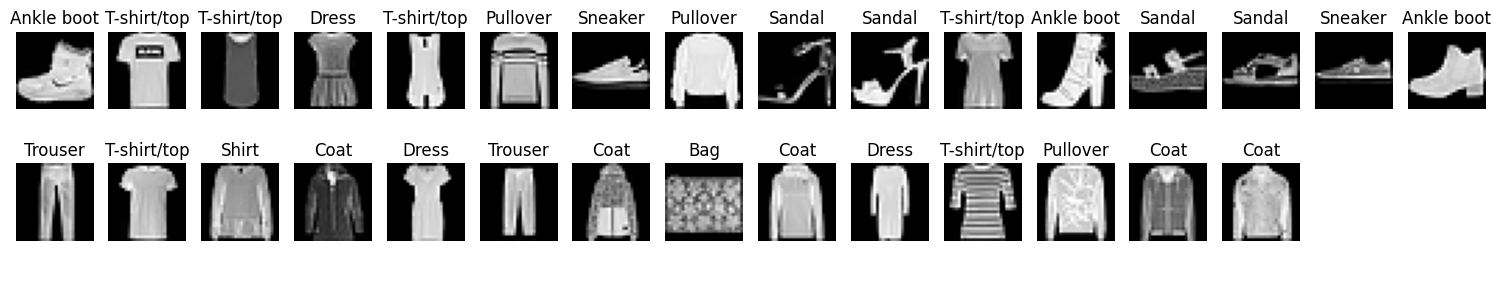

In [19]:
def batch_image_viewer(images,class_ids, n_cols=16):
    num_image = len(images)
    n_rows = num_image // n_cols
    fig , ax = plt.subplots(n_rows + 1, n_cols, figsize=(15, n_rows*3))
    ax = ax.flatten()
    for i in range(num_image):
        ax[i].imshow(images[i], cmap="gray")
        ax[i].axis(False)
        ax[i].set_title(class_names[class_ids[i]])
    for j in range(num_image,len(ax)):
        ax[j].axis(False)
    plt.tight_layout()
    plt.show()

batch_image_viewer(X_train[:30],y_train[:30])

In [20]:
def get_model():
    return tf.keras.Sequential([
        tf.keras.layers.Input(shape=(28,28)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Rescaling(scale=1./255),
        tf.keras.layers.Dense(128, activation="relu", kernel_initializer="he_normal"),
        tf.keras.layers.Dense(10)
    ])

In [21]:
@tf.function
def training_step(X,y):
    with tf.GradientTape() as tape:
        logits = model(X, training=True)
        loss_value = loss_fn(y, logits)
    gradients = tape.gradient(loss_value, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    train_metric_fn.update_state(y, logits)
    return loss_value

In [22]:
@tf.function
def validation_step(X_v,y_v):
    logits = model(X_v, training=False)
    val_metric_fn.update_state(y_v, logits)

In [23]:
tf.keras.utils.clear_session()
tf.keras.utils.set_random_seed(42)
train_len = len(X_train)
n_steps = int(tf.math.ceil(train_len / batch_size))
n_epochs = 10
optimizer = tf.keras.optimizers.Adam()
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
train_metric_fn = tf.keras.metrics.SparseCategoricalAccuracy()
val_metric_fn = tf.keras.metrics.SparseCategoricalAccuracy()
model = get_model()

In [24]:
%%time

for epoch in range(1, n_epochs+1):
    for step, (X_batch, y_batch) in enumerate(train_ds, start=1):
        loss_value = training_step(X_batch, y_batch)

        if step % 20 == 0:
            print(f"\r epoch {epoch}/{n_epochs} - step {step}/{n_steps} - loss: {loss_value.numpy():.4f}", end = "" if step < n_steps else " ")
    
    for X_batch_val, y_batch_val in val_ds:
        validation_step(X_batch_val, y_batch_val)

    print(f" - train accuracy: {float(train_metric_fn.result()):.4f} | val accuracy: {float(val_metric_fn.result()):.4f}")
    train_metric_fn.reset_state()
    val_metric_fn.reset_state()

 epoch 1/10 - step 1860/1875 - loss: 0.4709 - train accuracy: 0.8262 | val accuracy: 0.8441
 epoch 2/10 - step 1860/1875 - loss: 0.3710 - train accuracy: 0.8652 | val accuracy: 0.8533
 epoch 3/10 - step 1860/1875 - loss: 0.3565 - train accuracy: 0.8784 | val accuracy: 0.8630
 epoch 4/10 - step 1860/1875 - loss: 0.3438 - train accuracy: 0.8865 | val accuracy: 0.8650
 epoch 5/10 - step 1860/1875 - loss: 0.2873 - train accuracy: 0.8931 | val accuracy: 0.8698
 epoch 6/10 - step 1860/1875 - loss: 0.3233 - train accuracy: 0.8988 | val accuracy: 0.8696
 epoch 7/10 - step 1860/1875 - loss: 0.2611 - train accuracy: 0.9024 | val accuracy: 0.8697
 epoch 8/10 - step 1860/1875 - loss: 0.2928 - train accuracy: 0.9076 | val accuracy: 0.8738
 epoch 9/10 - step 1860/1875 - loss: 0.2936 - train accuracy: 0.9112 | val accuracy: 0.8779
 epoch 10/10 - step 1860/1875 - loss: 0.2706 - train accuracy: 0.9149 | val accuracy: 0.8743
CPU times: total: 17.4 s
Wall time: 25.1 s
